In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression

In [3]:
df = pd.read_csv('measurements.csv')

In [4]:
df.head()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
2,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
3,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
4,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   distance       388 non-null    object
 1   consume        388 non-null    object
 2   speed          388 non-null    int64 
 3   temp_inside    376 non-null    object
 4   temp_outside   388 non-null    int64 
 5   specials       93 non-null     object
 6   gas_type       388 non-null    object
 7   AC             388 non-null    int64 
 8   rain           388 non-null    int64 
 9   sun            388 non-null    int64 
 10  refill liters  13 non-null     object
 11  refill gas     13 non-null     object
dtypes: int64(5), object(7)
memory usage: 36.5+ KB


* <b>distance</b> is the distance in kilometers
* <b>consume</b> is the consumption in liters per 100 kilometers as seen in the display
* <b>speed</b> is the average speed.
* <b>temp_inside</b> is the setting of the heating or "NaN" if it was turned off
* <b>temp_outside</b> is the temperature outside, taken at the end of the ride.
* <b>specials</b> is a remark if it was raining, snowing or if the climatization was on ("AC")
* <b>gas type</b> is the gas type used during the last refill
* <b>AC</b> is one hot encoded, the special "AC". 1 for on, 0 for off.
* <b>rain</b> is one-hot-encoded, the special "rain" and "snow". 1 for it was raining/snowing, 0 for it was good weather.
* <b>sun</b> is one-hot-encoded, this means it was sunny enough outside so that the car felt warm when getting into itd

In [6]:
cols = ['distance', 'consume', 'temp_inside', 'temp_outside', 'refill liters']

# convert numerical dtype to float
df[cols] = df[cols].apply(lambda x: x.str.replace(',', '.') if x.dtype == 'object' else x, axis=0).astype(np.float64)

<b>refill liters</b> and <b>refill gas</b> is refill data, but there is few entries so drop it now <br/>
<b>specials</b> is already encoded, so drop them too

In [7]:
# let's see how specials feature is encoded
df.loc[~df['specials'].isnull(), ['specials', 'AC', 'rain', 'sun']].value_counts()

specials            AC  rain  sun
rain                0   1     0      32
sun                 0   0     1      27
AC rain             1   1     0       9
ac                  1   0     0       7
AC                  1   0     0       6
snow                0   1     0       3
sun ac              1   0     1       3
AC Sun              1   0     1       1
AC snow             1   1     0       1
AC sun              1   0     1       1
ac                  0   0     0       1
ac rain             1   1     0       1
half rain half sun  0   1     0       1
dtype: int64

In [8]:
df_ppr = df.drop(['refill liters', 'refill gas', 'specials'], axis=1)

df_ppr.head()

,distance,consume,speed,temp_inside,temp_outside,gas_type,AC,rain,sun
0,28.0,5.0,26,21.5,12.0,E10,0,0,0
1,12.0,4.2,30,21.5,13.0,E10,0,0,0
2,11.2,5.5,38,21.5,15.0,E10,0,0,0
3,12.9,3.9,36,21.5,14.0,E10,0,0,0
4,18.5,4.5,46,21.5,15.0,E10,0,0,0


In [9]:
# indicator if the heating was not used at all
df_ppr['heating_off']=df_ppr['temp_inside'].isnull().apply(int)

# if the heating was turned completely off, replace the inside temperature by the outside temperature
df_ppr['temp_inside'] = df_ppr['temp_inside'].fillna(df_ppr['temp_outside'])

# get the temperature difference
df_ppr['temp_diff'] = df_ppr['temp_inside'] - df_ppr['temp_outside']
df_ppr['temp_diff_square'] = df_ppr['temp_diff']**2

In [10]:
df_ppr[['heating_off', 'AC']].value_counts()

heating_off  AC
0            0     346
             1      30
1            0      12
dtype: int64

In [11]:
# gas_type one-hot encoding
df_ppr = pd.concat([df_ppr, pd.get_dummies(df_ppr['gas_type'], prefix='gas_type', drop_first=True)], axis=1)
df_ppr = df_ppr.drop('gas_type', axis=1)

df_ppr.head()


,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,heating_off,temp_diff,temp_diff_square,gas_type_SP98
0,28.0,5.0,26,21.5,12.0,0,0,0,0,9.5,90.25,0
1,12.0,4.2,30,21.5,13.0,0,0,0,0,8.5,72.25,0
2,11.2,5.5,38,21.5,15.0,0,0,0,0,6.5,42.25,0
3,12.9,3.9,36,21.5,14.0,0,0,0,0,7.5,56.25,0
4,18.5,4.5,46,21.5,15.0,0,0,0,0,6.5,42.25,0


In [12]:
numerical = ['consume', 'distance', 'speed', 'temp_inside', 'temp_outside', 'temp_diff', 'temp_diff_square']
numerical_sub_consume = ['distance', 'speed', 'temp_inside', 'temp_outside', 'temp_diff', 'temp_diff_square']
categorical = ['AC', 'rain', 'sun', 'heating_off', 'gas_type_SP98']

In [13]:
df_ppr[numerical].describe().T

,count,mean,std,min,25%,50%,75%,max
consume,388.0,4.912371,1.033172,3.3,4.30,4.70,5.3000,12.2
distance,388.0,19.652835,22.667837,1.3,11.80,14.60,19.0000,216.1
speed,388.0,41.927835,13.598524,14.0,32.75,40.50,50.0000,90.0
temp_inside,388.0,21.619845,2.116551,8.0,21.50,22.00,22.5000,25.5
temp_outside,388.0,11.358247,6.991542,-5.0,7.00,10.00,16.0000,31.0
temp_diff,388.0,10.261598,6.910315,-8.0,6.00,11.50,14.6250,26.0
temp_diff_square,388.0,152.929768,138.213066,0.0,36.00,132.25,213.9375,676.0


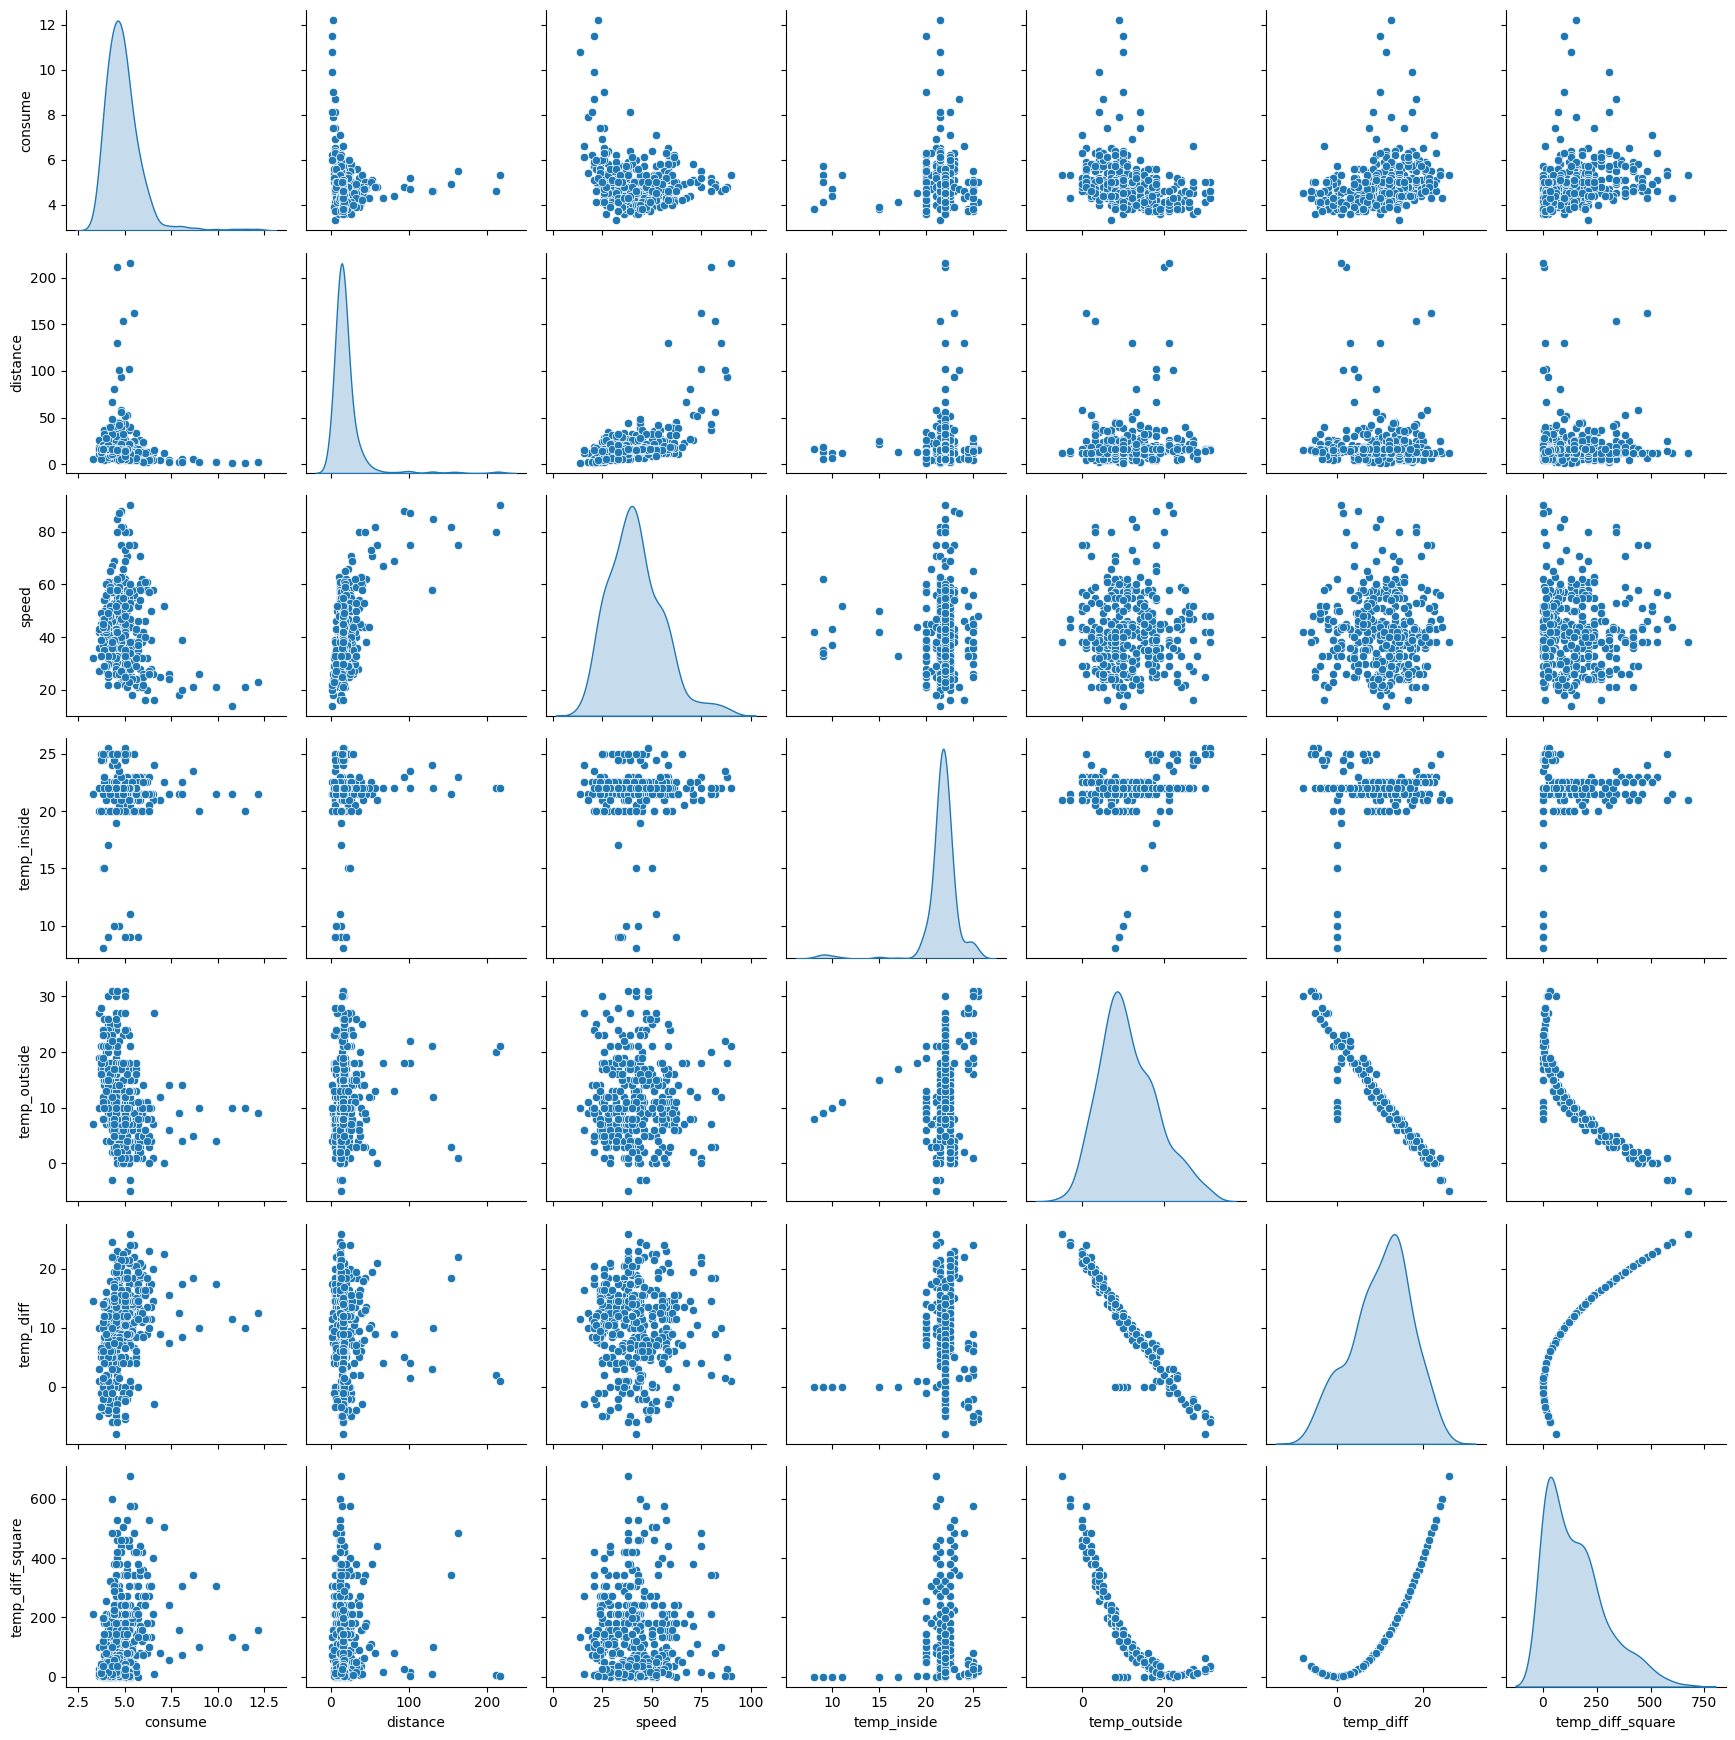

In [14]:
sns.pairplot(df_ppr[numerical], diag_kind='kde')
plt.tight_layout()
plt.show()

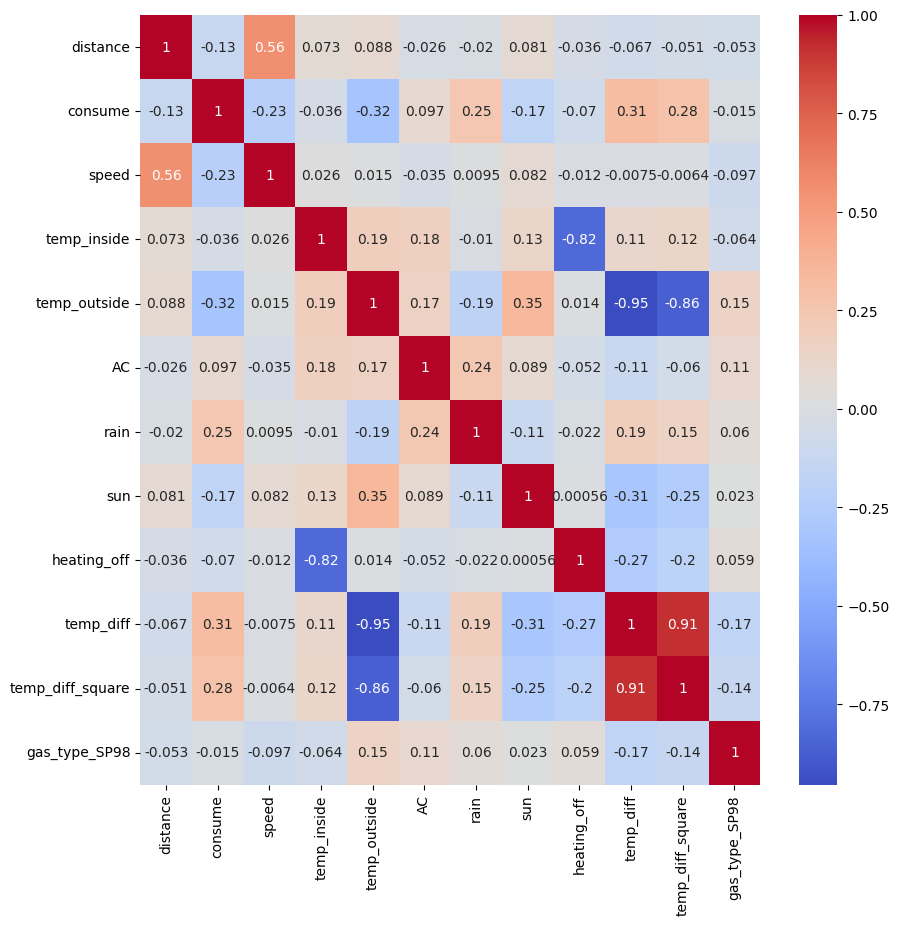

In [15]:
cm = df_ppr.corr()
fig = sns.heatmap(cm, annot=True, cmap='coolwarm')
fig.figure.set_size_inches(10, 10)

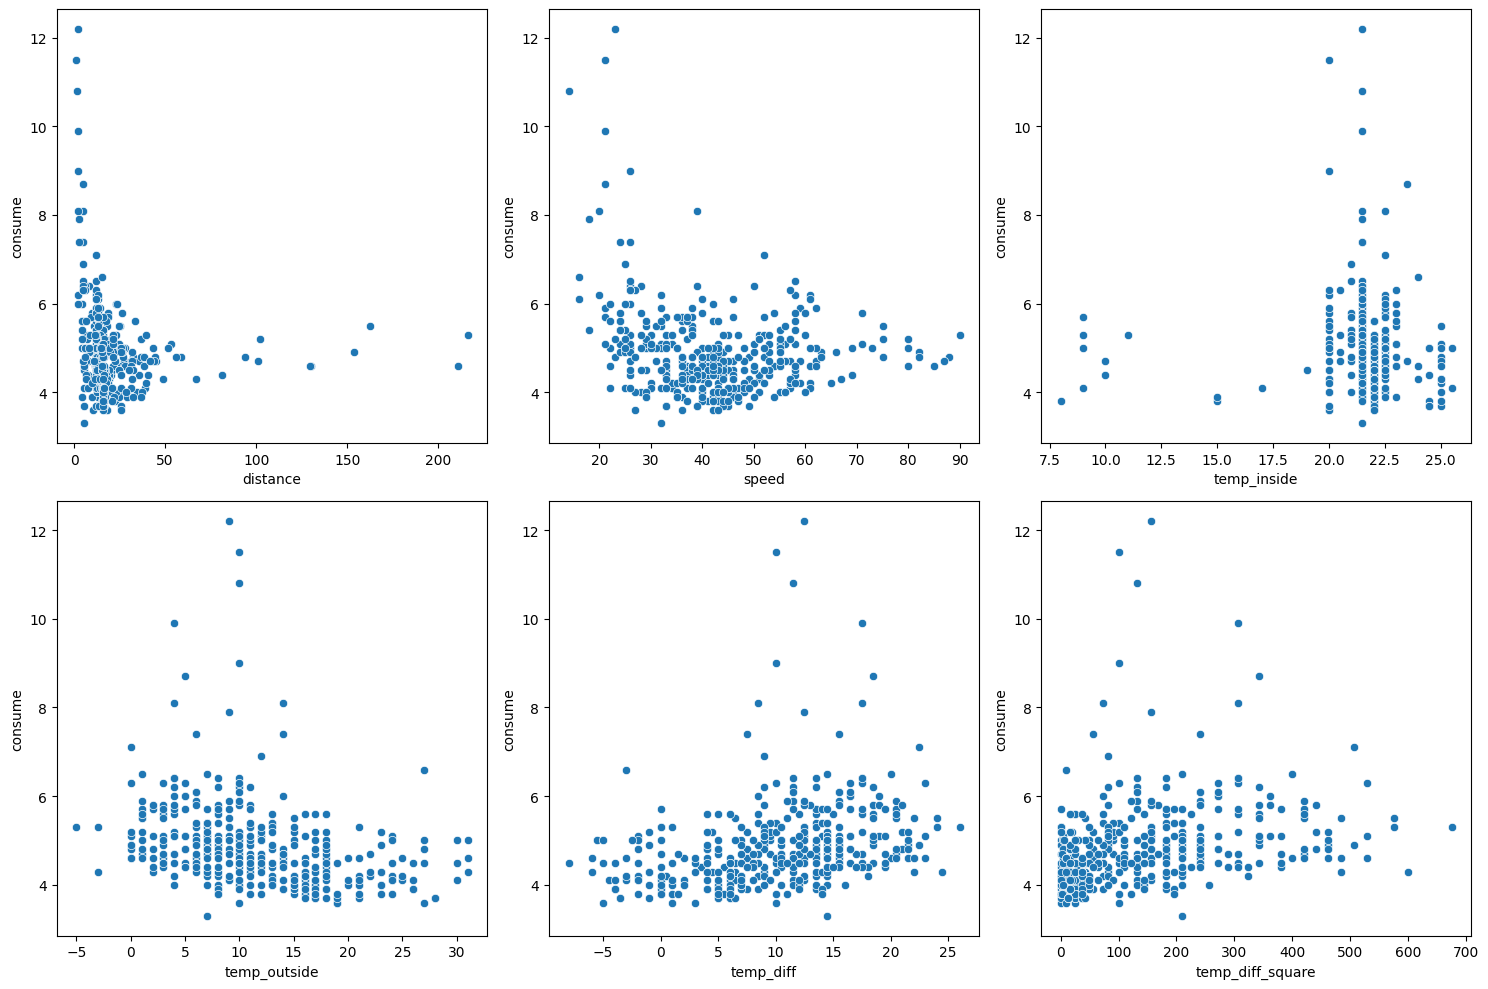

In [16]:
# scatter plot for consume vs all numerical features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, col in enumerate(numerical_sub_consume):
    sns.scatterplot(x=col, y='consume', data=df_ppr, ax=axes[i//3, i%3])
plt.tight_layout()

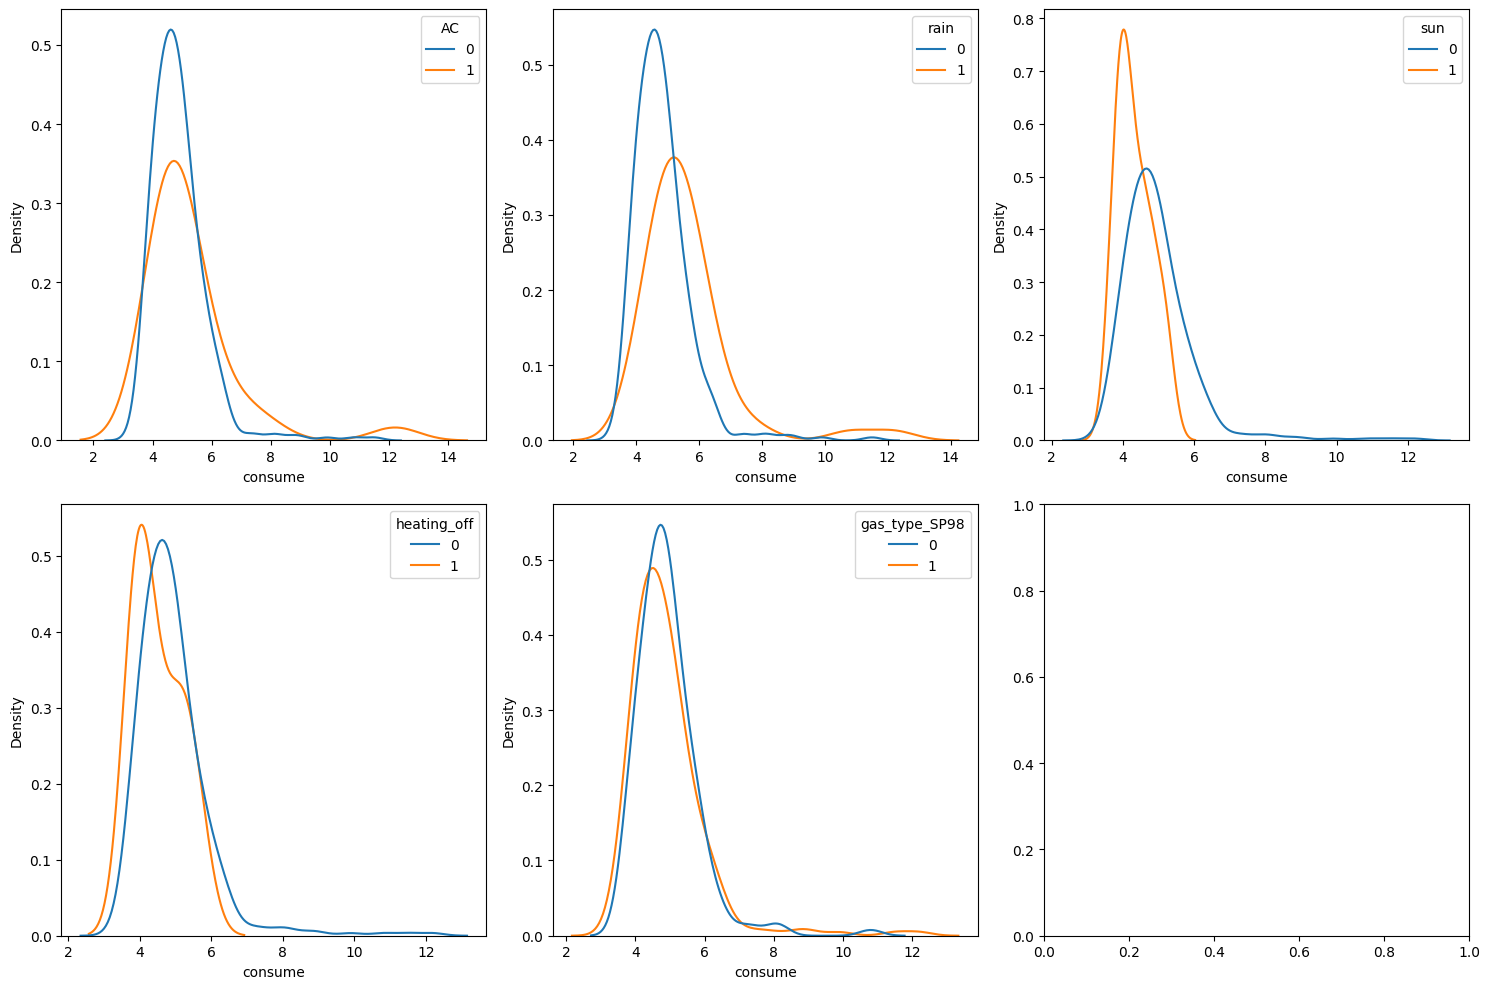

In [21]:
# kde plot for consume vs all categorical features
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, col in enumerate(categorical):
    sns.kdeplot(x='consume', hue=col, data=df_ppr, ax=axes[i//3, i%3], common_norm=False)
plt.tight_layout()


In [23]:
# split the data into train and test
X = df_ppr.drop('consume', axis=1)
y = df_ppr['consume']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [24]:
class CustomLinearRegression(BaseEstimator):
    def __init__(self, learning_rate=0.01, n_iterations=1000, epsilon=1e-5):
        self.learning_rate = learning_rate
        self.n_iterations = n_iterations
        self.epsilon = epsilon
        self.weights = None
        self.bias = None
        self.loss_history = []
    
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.weights = np.zeros(n_features)
        self.bias = 0
        delta = np.ones_like(self.weights)
        iteration = 0
        
        while np.linalg.norm(delta) > self.epsilon and iteration < self.n_iterations:
            y_predicted = np.dot(X, self.weights) + self.bias
            
            # compute loss and gradients
            loss = 1/(2*n_samples) * np.sum(np.square(y_predicted - y))
            dw = (1/n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1/n_samples) * np.sum(y_predicted - y)
            
            # update parameters and loss history
            delta = self.learning_rate * dw
            self.weights -= delta
            self.bias -= self.learning_rate * db
            self.loss_history.append(loss)
            
            iteration += 1
    
    def predict(self, X):
        y_predicted = np.dot(X, self.weights) + self.bias
        return y_predicted


In [29]:
# write evaluation function with printing results
def evaluate(y_true, y_pred, verbose=False):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    if verbose:
        print(f'MSE: {mse:.3f}')
        print(f'RMSE: {rmse:.3f}')
        print(f'MAE: {mae:.3f}')
        print(f'R2: {r2:.3f}')
    
    return mse, rmse, mae, r2

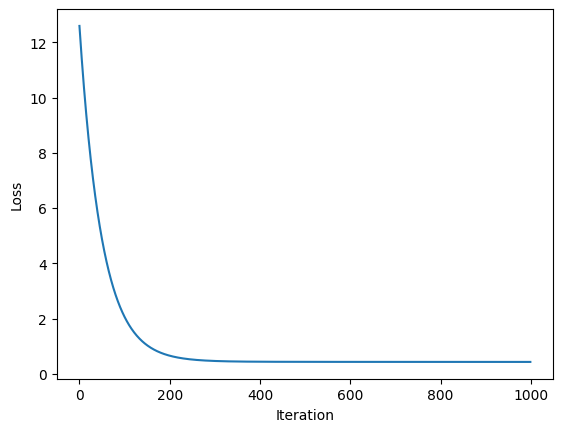

In [33]:
# train the model using custom linear regression
custom_lr = CustomLinearRegression()
custom_lr.fit(X_train_scaled, y_train)

# plot the loss history
plt.plot(custom_lr.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

In [42]:
# predict on the train and test set
y_train_pred_custom = custom_lr.predict(X_train_scaled)
y_test_pred_custom = custom_lr.predict(X_test_scaled)

results = pd.DataFrame(
    [evaluate(y_train, y_train_pred_custom), evaluate(y_test, y_test_pred_custom)], 
    index=pd.MultiIndex.from_tuples([('Custom lr', 'Train'), ('Custom lr', 'Test')], 
    names=['Model', 'Set']), 
    columns=['MSE', 'RMSE', 'MAE', 'R2']
)
results

MSE      RMSE       MAE        R2
Model     Set                                          
Custom lr Train  0.857290  0.925899  0.614316  0.223590
          Test   0.787767  0.887562  0.634748  0.131752

In [43]:
results

MSE      RMSE       MAE        R2
Model     Set                                          
Custom lr Train  0.857290  0.925899  0.614316  0.223590
          Test   0.787767  0.887562  0.634748  0.131752

In [44]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

models = {
    'Linear regression': LinearRegression(),
    'Ridge': Ridge(),
    'Lasso': Lasso()
}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_train_pred = model.predict(X_train_scaled)
    y_test_pred = model.predict(X_test_scaled)
    results.loc[(name, 'Train'), :] = evaluate(y_train, y_train_pred)
    results.loc[(name, 'Test'), :] = evaluate(y_test, y_test_pred)

results

MSE      RMSE       MAE        R2
Model             Set                                          
Custom lr         Train  0.857290  0.925899  0.614316  0.223590
                  Test   0.787767  0.887562  0.634748  0.131752
Linear regression Train  0.856215  0.925319  0.615542  0.224563
                  Test   0.802807  0.895995  0.647724  0.115176
Ridge             Train  0.856227  0.925325  0.615196  0.224552
                  Test   0.800713  0.894826  0.646004  0.117483
Lasso             Train  1.104171  1.050795  0.683694  0.000000
                  Test   0.907913  0.952845  0.641266 -0.000669

In [ ]:
# hyperparameter tuning using cross validation
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [0.01]